In [1]:
import torchvision.models as models
import torch.nn as nn,pandas as pd,torch
from torchvision import transforms
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from regDataset import binary_acc,RegDataset
from regModels import RegModel,RegModelSeperateBlocks
import os,shutil
import cv2 as cv
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score,classification_report
import seaborn as sns

In [2]:
dfTest = pd.read_csv("/home/pictor/workspace/Akhil/Confidence/Data/RegData/TestReg.csv")
threshold = 0.8
metricCol = 'IoU'
label_function = lambda x: 0 if x<threshold else 1
dfTest.loc[:,'label'] = dfTest[metricCol].apply(label_function)
dfTest.head()

IoU  accuracy                                           predMask  \
0  0.529264  0.939565  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  0.764624  0.961272  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  0.000000  0.862231  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  0.878936  0.982976  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  0.136580  0.415025  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                              gtMask  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            RecInput  \
0  /home/pictor/workspace/Akhil/Confidence/Data/R...   
1  /home/pictor/workspace/Akhil/Confidence/Data/R...   
2  /home/pictor/workspace/Akhil/Confidence/Data/R...   
3  /home/pictor/workspace/Akhil/Confidence/Data/R...   
4  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                            InputImg  Epoch  Data  label  
0  /home/pictor/workspace/Akhil/Confidence/Data/R...    161  Test      0  
1  /home/pictor/workspace/Akhil/Confidence/Data/R...    101  Test      0  
2  /home/pictor/workspace/Akhil/Confidence/Data/R...     71  Test      0  
3  /home/pictor/workspace/Akhil/Confidence/Data/R...     91  Test      1  
4  /home/pictor/workspace/Akhil/Confidence/Data/R...      1  Test      0

In [3]:
dfTest.label.value_counts(1)

1    0.503518
0    0.496482
Name: label, dtype: float64

In [4]:
model_path = "/home/pictor/workspace/Akhil/Confidence/codes/trainReg.pt"
im_size = 512
batch_size = 1

In [5]:
device = torch.device("cuda")#"cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
preprocess_rgb = transforms.Compose([
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocess_grayscale = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((im_size,im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,), std=(0.229,)),
])

In [7]:
test_dataset = RegDataset(dfTest,
                            transform={'preprocess_rgb':preprocess_rgb,'preprocess_grayscale':preprocess_grayscale},
                            labelCol='label',device=device)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=False)

In [8]:
model = torch.load(model_path)
model.to(device)
lossFn = nn.CrossEntropyLoss()
model.eval()
y_pred_val = []
Y = []
with torch.no_grad():
    for val_batch in tqdm(test_dataloader):
        y_pred_val.append(model(val_batch))
        Y.append(val_batch['Y'])

y_pred_val = torch.vstack(y_pred_val)
Y = torch.vstack(Y).flatten()

  0%|          | 0/2985 [00:00<?, ?it/s]/home/pictor/.virtualenvs/ml_g6/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 2985/2985 [02:39<00:00, 18.72it/s]


In [9]:
Y = Y.to(device)
# y_pred_val.to(device);

In [10]:
test_loss = lossFn(y_pred_val,Y)
test_acc = binary_acc(y_pred_val,Y)

In [12]:
print(f'Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.3f}|')

Test Loss: 0.41438 | Test Acc: 81.000|


In [11]:
print(f'Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.3f}|')

Test Loss: 0.41338 | Test Acc: 81.000|


In [12]:
ypred_prob = torch.exp(torch.log_softmax(y_pred_val, dim = 1))
_,labelPred = torch.max(ypred_prob,dim=1)
dfTest.loc[:,'pred'] = labelPred.cpu()
dfTest.loc[:,'confidence'] = ypred_prob[:,1].cpu()

In [13]:
tempDf0 = dfTest[dfTest.Epoch==0]
tempDf183 = dfTest[dfTest.Epoch==183]
tempDf0.shape,tempDf183.shape

((150, 11), (151, 11))

In [14]:
print("Accuray on Epoch 0 - ",accuracy_score(tempDf0.pred,tempDf0.label))
print("Accuray on Epoch 183 - ",accuracy_score(tempDf183.pred,tempDf183.label))

Accuray on Epoch 0 -  0.8466666666666667
Accuray on Epoch 183 -  0.8344370860927153


In [29]:
print("Accuray on Epoch 183 - ",accuracy_score(tempDf183.pred,tempDf183.label))

Accuray on Epoch 183 -  0.8344370860927153


In [16]:
roc_auc_score(dfTest.label,dfTest.confidence)

0.893607497907883

In [17]:
roc_auc_score(tempDf183.label,tempDf183.confidence)

0.8949739212897108

In [18]:
# roc_auc_score(tempDf0.label,tempDf0.confidence)

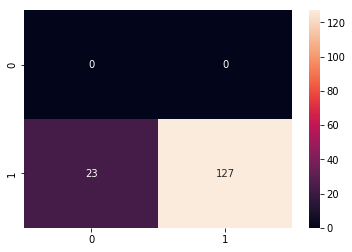

In [19]:
sns.heatmap(confusion_matrix(tempDf0.label,tempDf0.pred),annot=True,fmt='d');

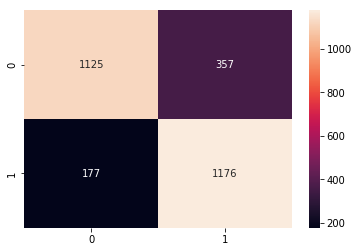

In [18]:
sns.heatmap(confusion_matrix(dfTest.label,dfTest.pred),annot=True,fmt='d');

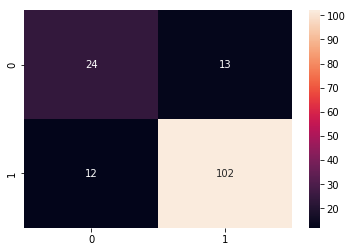

In [19]:
sns.heatmap(confusion_matrix(tempDf183.label,tempDf183.pred),annot=True,fmt='d');

In [20]:
print(classification_report(dfTest.label,dfTest.pred))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81      1482
           1       0.77      0.87      0.81      1353

    accuracy                           0.81      2835
   macro avg       0.82      0.81      0.81      2835
weighted avg       0.82      0.81      0.81      2835



In [21]:
print(classification_report(tempDf183.label,tempDf183.pred))

              precision    recall  f1-score   support

           0       0.67      0.65      0.66        37
           1       0.89      0.89      0.89       114

    accuracy                           0.83       151
   macro avg       0.78      0.77      0.77       151
weighted avg       0.83      0.83      0.83       151



In [28]:
dfTest.shape,tempDf183.shape

((2835, 12), (151, 12))

In [30]:
tempDf183.head(2)

Unnamed: 0       IoU  accuracy  \
13       14820  0.878864  0.982993   
33       14840  0.860784  0.981156   

                                             predMask  \
13  /home/pictor/workspace/Akhil/Confidence/Data/R...   
33  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                               gtMask  \
13  /home/pictor/workspace/Akhil/Confidence/Data/R...   
33  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                             RecInput  \
13  /home/pictor/workspace/Akhil/Confidence/Data/R...   
33  /home/pictor/workspace/Akhil/Confidence/Data/R...   

                                             InputImg  Epoch  Data  label  \
13  /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   
33  /home/pictor/workspace/Akhil/Confidence/Data/R...    183  Test      1   

    pred  confidence  
13     1    0.836908  
33     1    0.710920

In [39]:
prob = dfTest.confidence
for thr in [0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.8,0.9]:
    yp_temp = [1 if i>thr else 0 for i in prob]
    print(f"Thresh - {thr}, Acc - {accuracy_score(dfTest.label,yp_temp)}")

Thresh - 0.3, Acc - 0.7537918871252205
Thresh - 0.4, Acc - 0.7897707231040564
Thresh - 0.5, Acc - 0.8116402116402116
Thresh - 0.55, Acc - 0.8158730158730159
Thresh - 0.6, Acc - 0.8158730158730159
Thresh - 0.65, Acc - 0.8067019400352734
Thresh - 0.7, Acc - 0.7763668430335097
Thresh - 0.8, Acc - 0.7061728395061728
Thresh - 0.9, Acc - 0.5992945326278659


In [25]:
perfDict = {
    'TP':{'label':1,'pred':1},
    'FP':{'label':0,'pred':1},

    'TN':{'label':0,'pred':0},
    'FN':{'label':1,'pred':0},
}

In [26]:
outPath = "/home/pictor/workspace/Akhil/Confidence/Data/trainRegMdlResults"
for lbl in perfDict:
    gtLbl,prdLbl = perfDict[lbl]['label'],perfDict[lbl]['pred']
    tmp = tempDf183[(tempDf183.label==gtLbl)&(tempDf183.pred==prdLbl)]
    dir = os.path.join(outPath,lbl)
    os.makedirs(dir,exist_ok=True)
    for inptImgPth,gtMskPth,RecPth,predMskPth in tmp[['InputImg','gtMask','RecInput','predMask']].values:
        shutil.copy2(inptImgPth,dir)
        shutil.copy2(RecPth,dir)
        shutil.copy2(predMskPth,dir)
        img = cv.imread(gtMskPth)
        img[img==1]=255
        img[img==2]=0
        cv.imwrite(os.path.join(dir,os.path.basename(gtMskPth).replace('tif','png')),img)
    tmp.to_csv(os.path.join(dir,'pred.csv'),index=False)

In [37]:
import numpy as np

In [53]:
outPath = "/home/pictor/workspace/Akhil/Confidence/Data/trainRegMdlResults2"
for lbl in perfDict:
    gtLbl,prdLbl = perfDict[lbl]['label'],perfDict[lbl]['pred']
    tmp = tempDf183[(tempDf183.label==gtLbl)&(tempDf183.pred==prdLbl)]
    dir = os.path.join(outPath,lbl)
    os.makedirs(dir,exist_ok=True)
    for inptImgPth,gtMskPth,RecPth,predMskPth in tqdm(tmp[['InputImg','gtMask','RecInput','predMask']].values):
        inptImg = cv.imread(inptImgPth)
        recImg = cv.imread(RecPth)
        predMaskImg = cv.imread(predMskPth)
        gtMaskImg = cv.imread(gtMskPth)
        gtMaskImg[gtMaskImg==1]=255
        gtMaskImg[gtMaskImg==2]=0

        h8 = 400
        wdth = 400
        inptImg = cv.resize(inptImg,(h8,wdth))
        recImg = cv.resize(recImg,(h8,wdth))
        predMaskImg = cv.resize(predMaskImg,(h8,wdth))
        gtMaskImg = cv.resize(gtMaskImg,(h8,wdth))
        
        w8Brdr = np.ones((400,1,3))*255

        img = np.hstack([inptImg,w8Brdr,gtMaskImg,w8Brdr,predMaskImg,w8Brdr,recImg])
        cv.imwrite(os.path.join(dir,os.path.basename(gtMskPth).replace('tif','png')),img)
    tmp.to_csv(os.path.join(dir,'pred.csv'),index=False)

100%|██████████| 12/12 [00:00<00:00, 12.90it/s]


In [48]:
inptImg.shape,gtMaskImg.shape,predMaskImg.shape,recImg.shape,w8Brdr.shape

((400, 400, 3), (400, 400, 3), (400, 400, 3), (400, 400, 3), (20, 400, 3))

In [50]:
np.vstack([inptImg,w8Brdr,gtMaskImg,w8Brdr,predMaskImg,w8Brdr,recImg]).shape

(1660, 400, 3)